:::{canonical-tutorial} tutorials/basics/clustering-2017
:::

# Preprocessing and clustering 3k PBMCs (legacy workflow)

This is the one download as a raw file from scanpy tutorial github repo

https://github.com/scverse/scanpy-tutorials/tree/main

pbmc3k.ipynb

We modified to make it work.


In [1]:
from __future__ import annotations

import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc

/config/workspace/.venv/lib/python3.10/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In May 2017, this started out as a demonstration that Scanpy would allow to reproduce most of Seurat's [guided clustering tutorial](http://satijalab.org/seurat/pbmc3k_tutorial.html) {cite:p}`Satija2015`.

We gratefully acknowledge Seurat's authors for the tutorial! In the meanwhile, we have added and removed a few pieces.

The data consist of *3k PBMCs from a Healthy Donor* and are freely available from 10x Genomics ([here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz) from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)). On a unix system, you can uncomment and run the following to download and unpack the data. The last line creates a directory for writing processed data.

In [2]:
#%%bash
!mkdir -p data write
!test -f ./data/pbmc3k_filtered_gene_bc_matrices.tar.gz || curl https://cf.10xgenomics.com/samples/cell/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -o ./data/pbmc3k_filtered_gene_bc_matrices.tar.gz 
!cd data && tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz

:::{note}
Download the notebook by clicking on the _Edit on GitHub_ button. On GitHub, you can download using the _Raw_ button via right-click and _Save Link As_. Alternatively, download the whole [scanpy-tutorial](https://github.com/theislab/scanpy-tutorials) repository.
:::

:::{note}
In Jupyter notebooks and lab, you can see the documentation for a python function by hitting ``SHIFT + TAB``. Hit it twice to expand the view.
:::

In [3]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.set_figure_params(dpi=80, facecolor="white")
sc.logging.print_header()

jedi	0.19.2
jaraco.functools	4.4.0
numba	0.63.1
pillow	12.0.0
h5py	3.15.1
python-dateutil	2.9.0.post0
jaraco.classes	3.4.0
cycler	0.12.1
psutil	7.2.0
pure_eval	0.2.3
six	1.17.0
jaraco.text	3.12.1
texttable	1.7.0
pexpect	4.9.0
kiwisolver	1.4.9
tornado	6.5.4
executing	2.2.1
jaraco.context	6.0.2
asttokens	3.0.1
prompt_toolkit	3.0.52
llvmlite	0.46.0
wcwidth	0.2.14
setuptools	80.9.0
ipywidgets	8.1.8
natsort	8.4.0
decorator	5.2.1
ipython	8.37.0
pytz	2025.2
jaraco.collections	5.1.0
charset-normalizer	3.4.4
louvain	0.8.2
plotly	6.5.0
debugpy	1.8.19
igraph	0.11.9
parso	0.8.5
typing	3.10.0.0
joblib	1.5.3
defusedxml	0.7.1
backports.tarfile	1.2.0
PyYAML	6.0.3
stack-data	0.6.3
----	----
Python	3.10.19 (main, Dec  9 2025, 19:03:08) [Clang 21.1.4 ]
OS	Linux-6.14.0-29-generic-x86_64-with-glibc2.39
CPU	48 logical CPU cores, x86_64
GPU	ID: 0, NVIDIA T400 4GB, Driver: 575.64.03, Memory: 4096 MiB
Updated	2026-01-04 00:56

In [4]:
results_file = "write/pbmc3k.h5ad"  # the file that will store the analysis results

Read in the count matrix into an {class}`~anndata.AnnData` object, which holds many slots for annotations and different representations of the data. It also comes with its own HDF5-based file format: `.h5ad`.

In [5]:
adata = sc.read_10x_mtx(
    "data/filtered_gene_bc_matrices/hg19/",  # the directory with the `.mtx` file
    var_names="gene_symbols",  # use gene symbols for the variable names (variables-axis index)
    cache=True,  # write a cache file for faster subsequent reading
)

... writing an h5ad cache file to speedup reading next time


In [6]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

:::{note}
See {doc}`anndata:tutorials/notebooks/getting-started` for a more comprehensive introduction to `AnnData`.
:::

In [7]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [8]:
# To match R results, do: `adata.X = adata.X.astype("int32")`
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

## Preprocessing

Show those genes that yield the highest fraction of counts in each single cell, across all cells.

normalizing counts per cell
    finished (0:00:00)


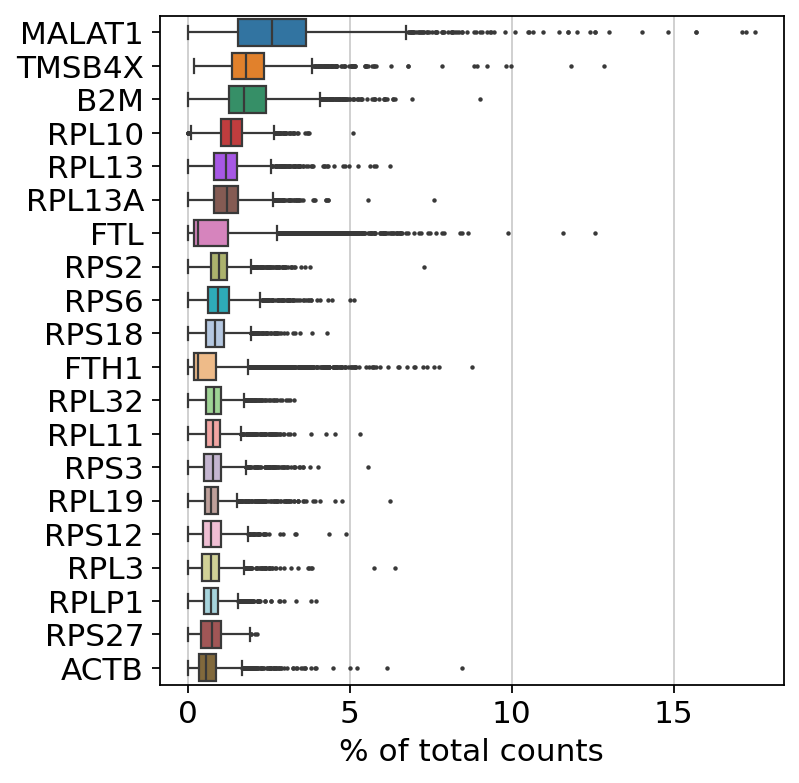

In [9]:
sc.pl.highest_expr_genes(adata, n_top=20)

Basic filtering:

In [10]:
sc.pp.filter_cells(adata, min_genes=200)  # this does nothing, in this specific case
sc.pp.filter_genes(adata, min_cells=3)
adata

filtered out 19024 genes that are detected in less than 3 cells


AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'

Let's assemble some information about mitochondrial genes, which are important for quality control.

Citing from "Simple Single Cell" workflows {cite:p}`Lun2016`:

> High proportions are indicative of poor-quality cells {cite:p}`Islam2013,Ilicic2016`, possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

With `pp.calculate_qc_metrics`, we can compute many metrics very efficiently.

In [11]:
# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

A violin plot of some of the computed quality measures:

* the number of genes expressed in the count matrix
* the total counts per cell
* the percentage of counts in mitochondrial genes

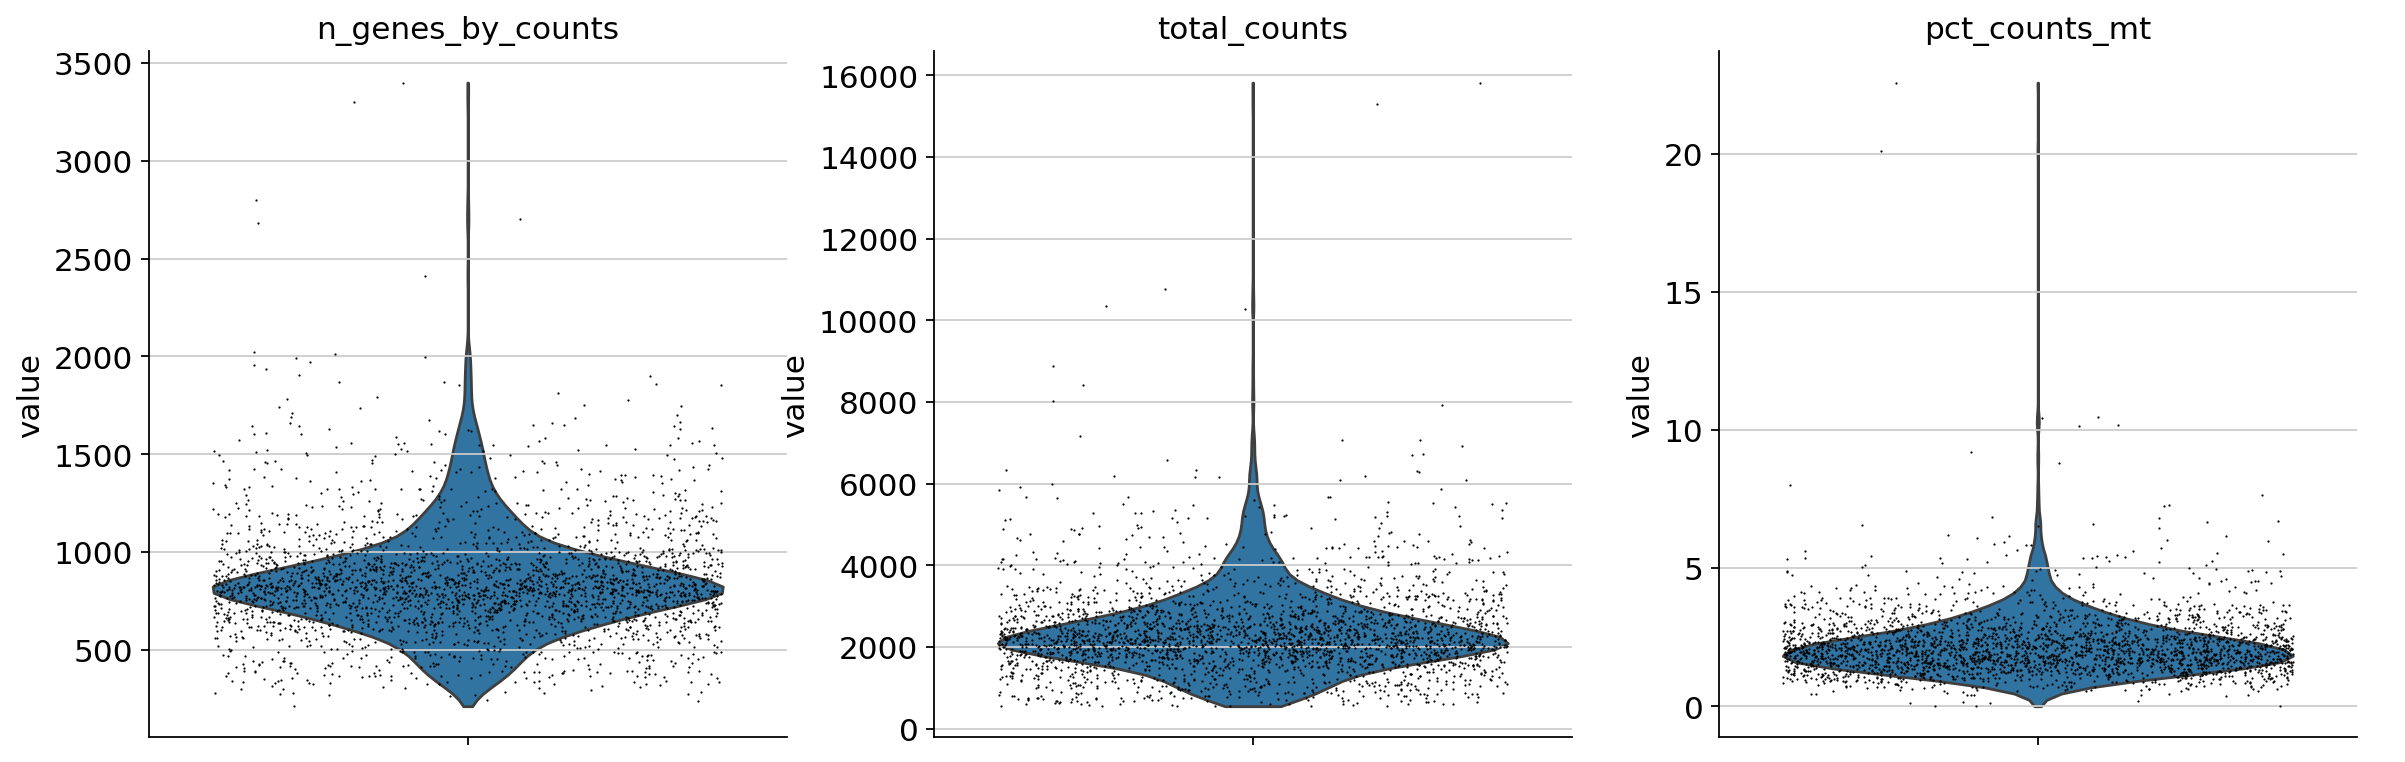

In [12]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

Remove cells that have too many mitochondrial genes expressed or too many total counts:

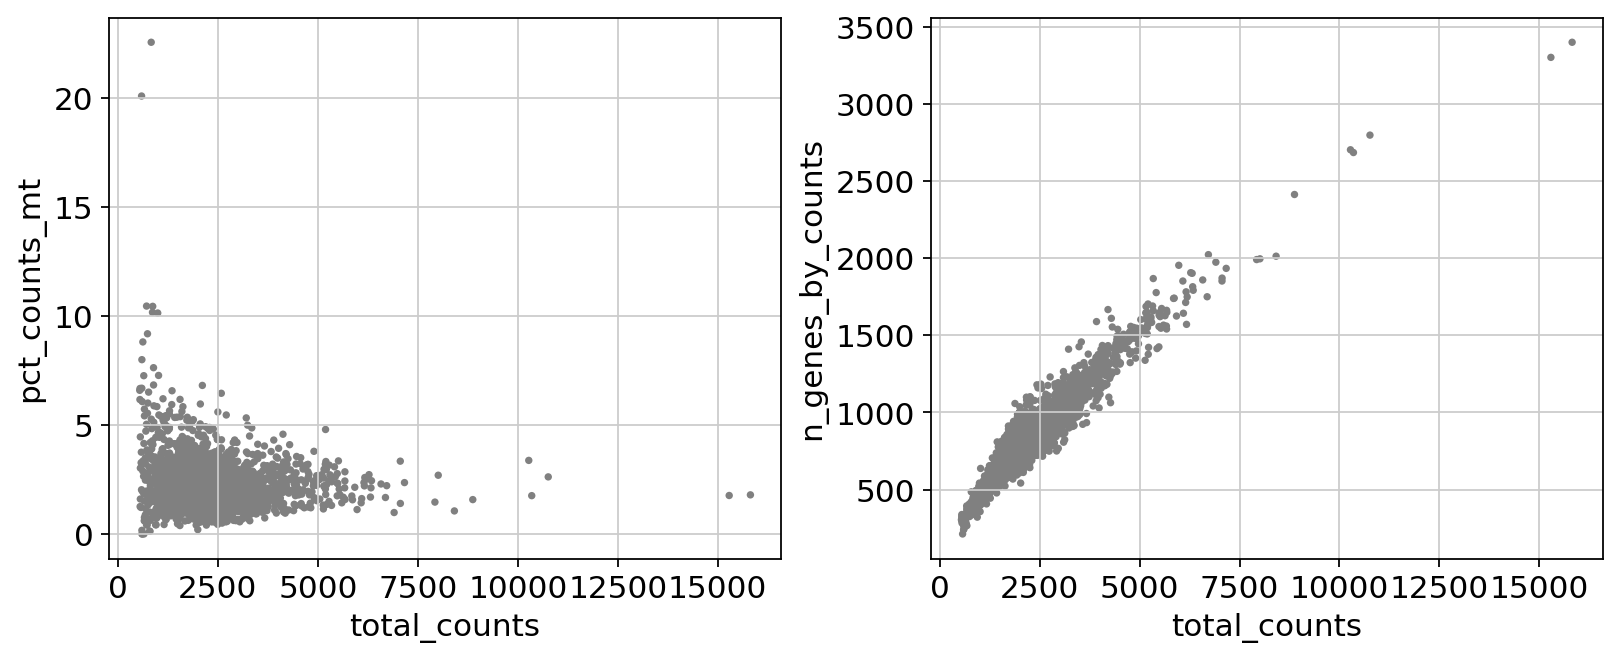

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), layout="constrained")
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt", show=False, ax=axs[0])
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", show=False, ax=axs[1]);

Actually do the filtering by slicing the `AnnData` object.

In [14]:
adata = adata[
    (adata.obs.n_genes_by_counts < 2500) & (adata.obs.n_genes_by_counts > 200) & (adata.obs.pct_counts_mt < 5),
    :,
].copy()
adata.layers["counts"] = adata.X.copy()

In [15]:
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'counts'

Total-count normalize (library-size correct) the data matrix $\mathbf{X}$ to 10,000 reads per cell, so that counts become comparable among cells.

In [16]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


Logarithmize the data:

In [17]:
sc.pp.log1p(adata)

Identify highly-variable genes. Up to ties, this should match exactly the tutorial from Seurat: https://satijalab.org/seurat/articles/pbmc3k_tutorial

In [19]:
sc.pp.highly_variable_genes(
    adata,
    layer="counts",
    n_top_genes=2000,
    min_mean=0.0125,
    max_mean=3,
    min_disp=0.5,
    flavor="seurat_v3",
)

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


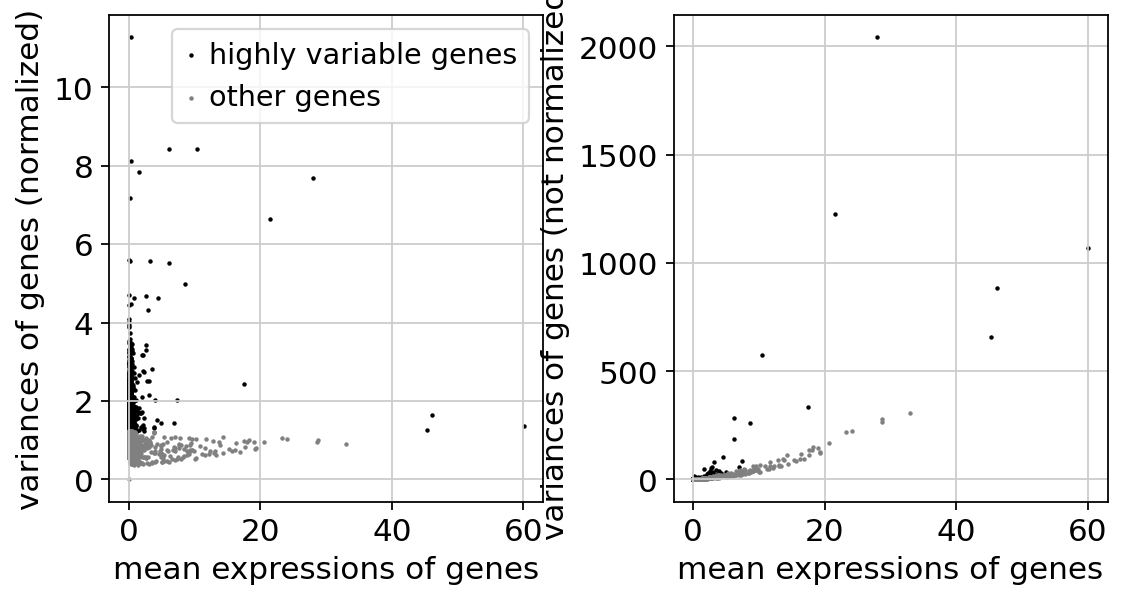

In [20]:
sc.pl.highly_variable_genes(adata)

:::{note}
The result of the previous highly-variable-genes detection is stored as an annotation in `.var["highly_variable"]` and auto-detected by PCA and hence, `sc.pp.neighbors` and subsequent manifold/graph tools. In that case, the step *actually do the filtering* below is unnecessary, too.
:::

Scale each gene to unit variance. Clip values exceeding standard deviation 10. To match [Seurat's pbmc 3k tutorial](https://satijalab.org/seurat/articles/pbmc3k_tutorial), you can elect to regress out only `pct_counts_mt` and subset (which appears to be optional in their tutorial).

In [23]:
adata.layers["scaled"] = adata.X.toarray()
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"], layer="scaled")
sc.pp.scale(adata, max_value=10, layer="scaled")

regressing out ['total_counts', 'pct_counts_mt']


    finished (0:00:00)


## Principal component analysis

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [24]:
sc.pp.pca(adata, layer="scaled", svd_solver="arpack")

computing PCA
    with n_comps=50
    finished (0:00:02)


We can make a scatter plot in the PCA coordinates, but we will not use that later on.

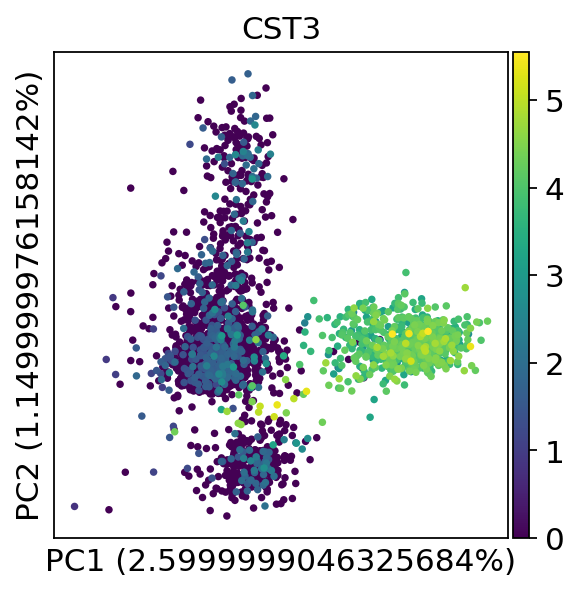

In [25]:
sc.pl.pca(adata, annotate_var_explained=True, color="CST3")

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`. In our experience, often a rough estimate of the number of PCs does fine.

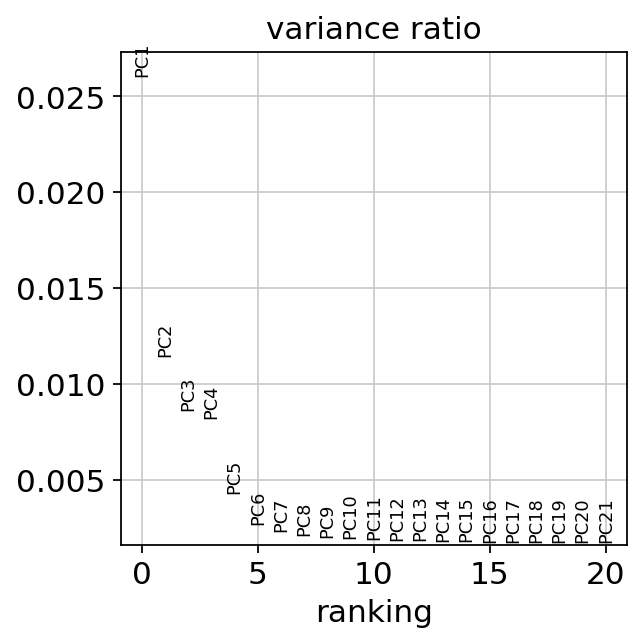

In [26]:
sc.pl.pca_variance_ratio(adata, n_pcs=20)

While our alogrithms differ, yielding slightly different components, the rankings match those found in [the Seurat tutorial](https://satijalab.org/seurat/articles/pbmc3k_tutorial) modulo the sign.

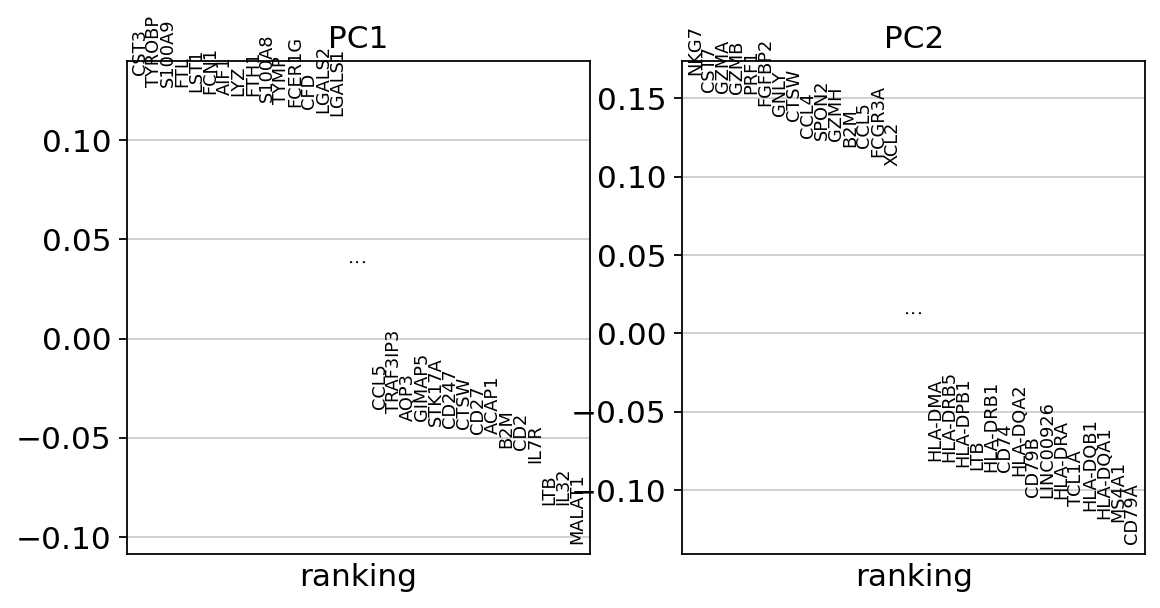

In [27]:
sc.pl.pca_loadings(adata, components=(1, 2), include_lowest=True)

## Computing the neighborhood graph

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of reproducing Seurat's results, let's take the following values.

In [28]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)


## Embedding the neighborhood graph

We suggest embedding the graph in two dimensions using UMAP {cite:p}`McInnes2018`, see below. It is potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preserves trajectories. In some ocassions, you might still observe disconnected clusters and similar connectivity violations. They can usually be remedied by running:

```Python
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')
```

In [29]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:05)


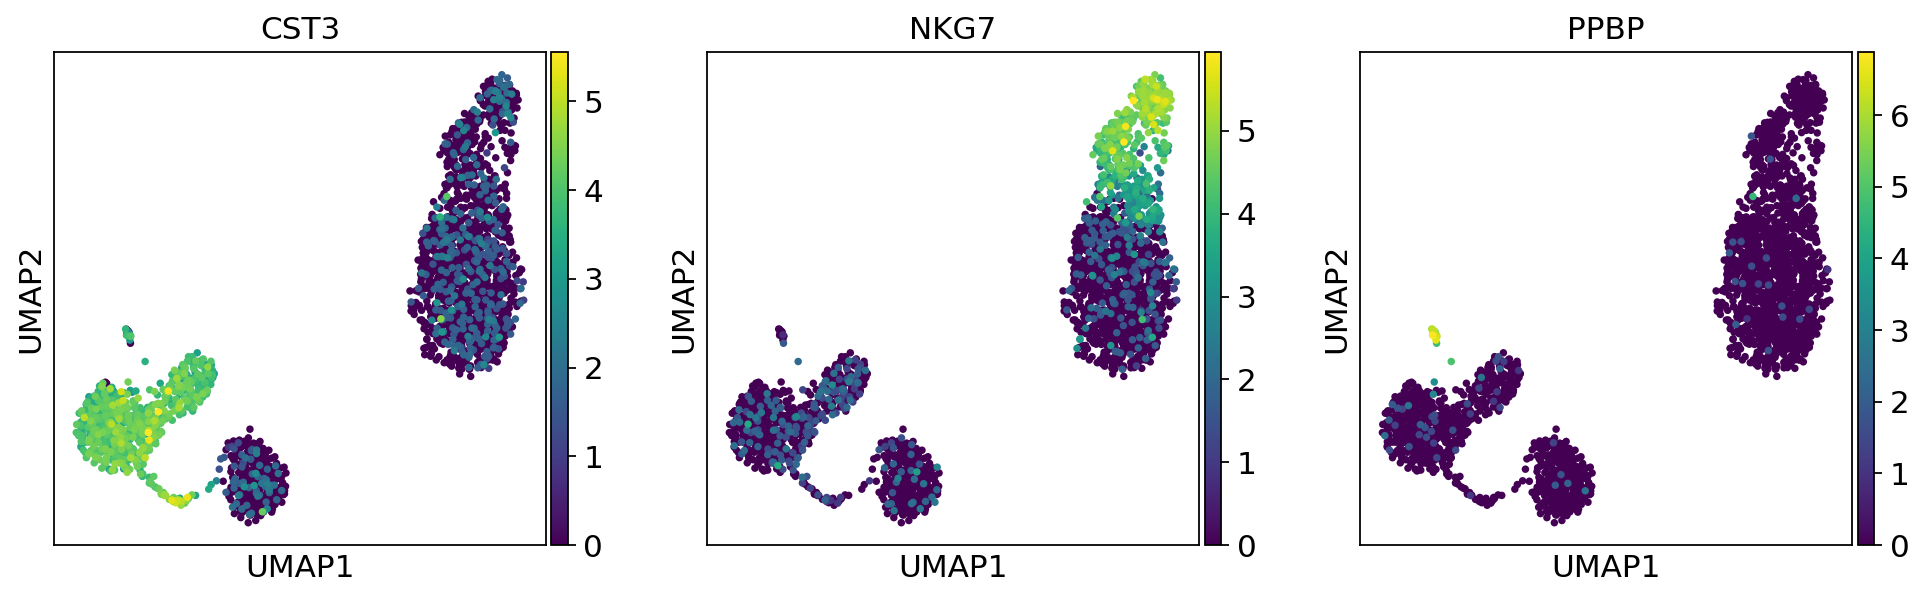

In [30]:
sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"])

As we set the `.X` attribute of `adata` to be the normalized data, the previous plots showed the normalized gene expression.
You can also plot the counts directly, or the "scaled_hvg" (normalized, logarithmized, and scaled) data.

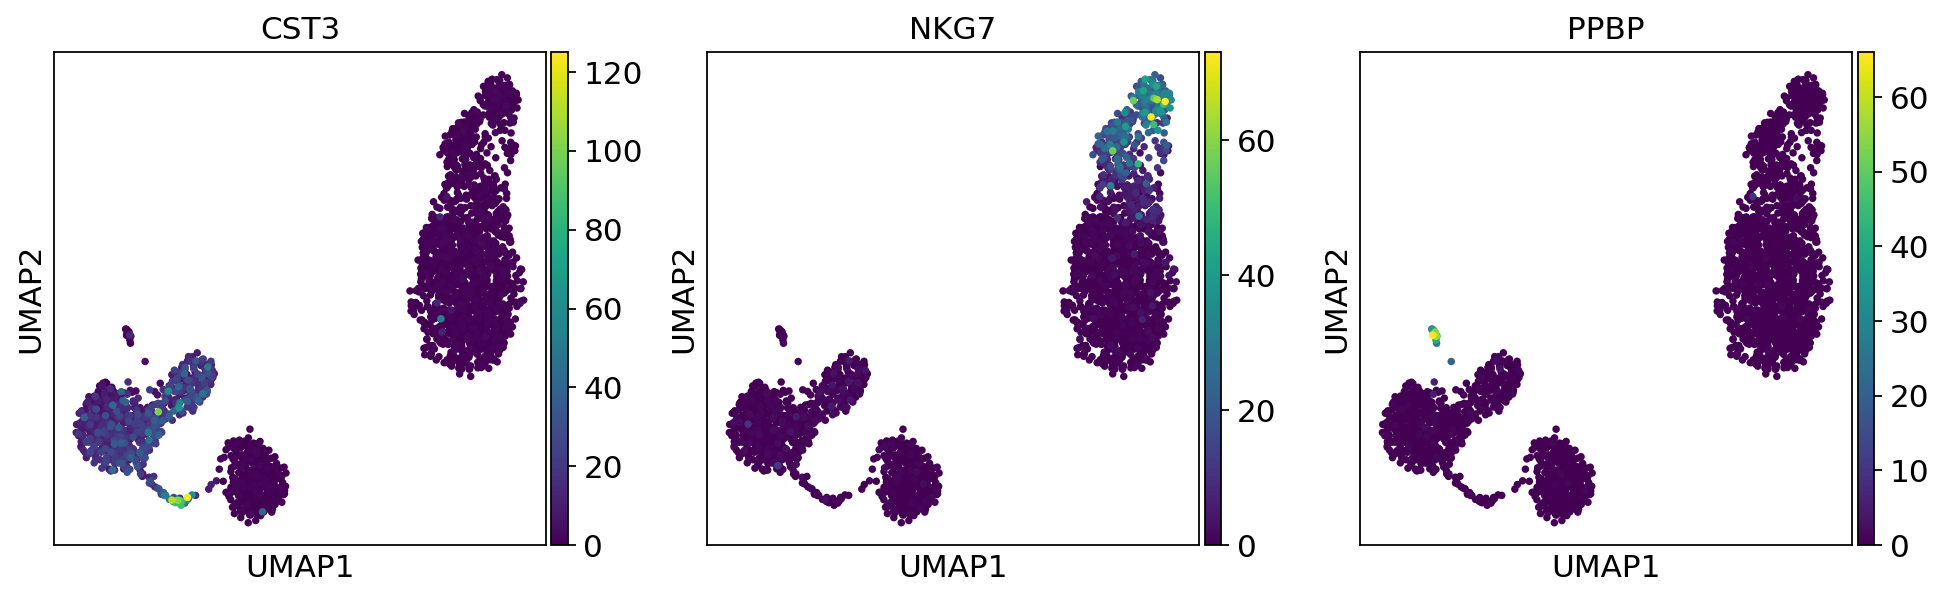

In [31]:
sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"], layer="counts")

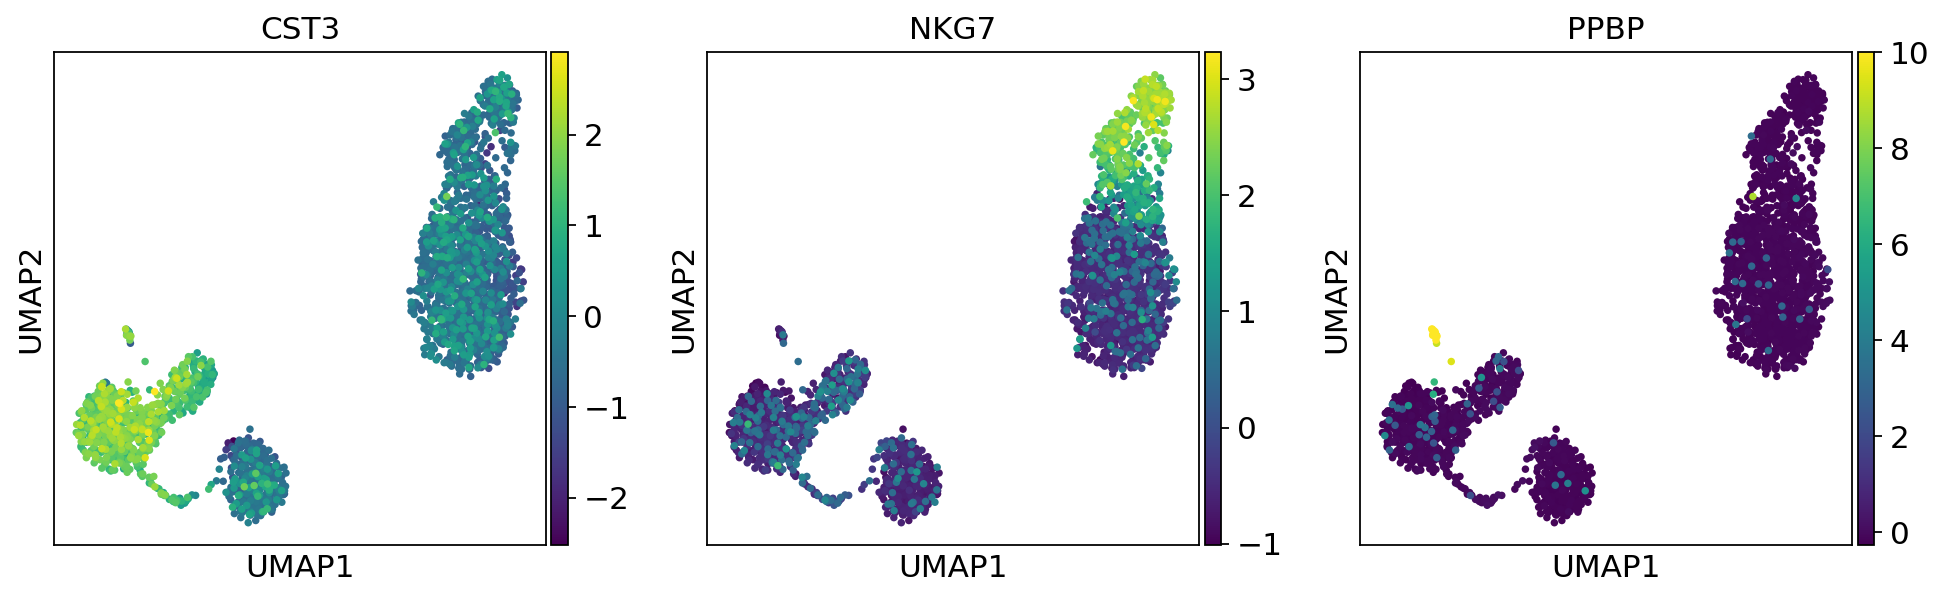

In [33]:
sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"], layer="scaled")

## Clustering the neighborhood graph

As with Seurat and many other frameworks, we recommend the Leiden graph-clustering method (community detection based on optimizing modularity) by {cite:t}`Traag2019`.
Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [34]:
sc.tl.leiden(
    adata,
    resolution=0.7,
    random_state=0,
    flavor="igraph",
    n_iterations=2,
    directed=False,
)
adata.obs["leiden"] = adata.obs["leiden"].copy()
adata.uns["leiden"] = adata.uns["leiden"].copy()
adata.obsm["X_umap"] = adata.obsm["X_umap"].copy()

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


Plot the clusters, which agree quite well with the result of Seurat.

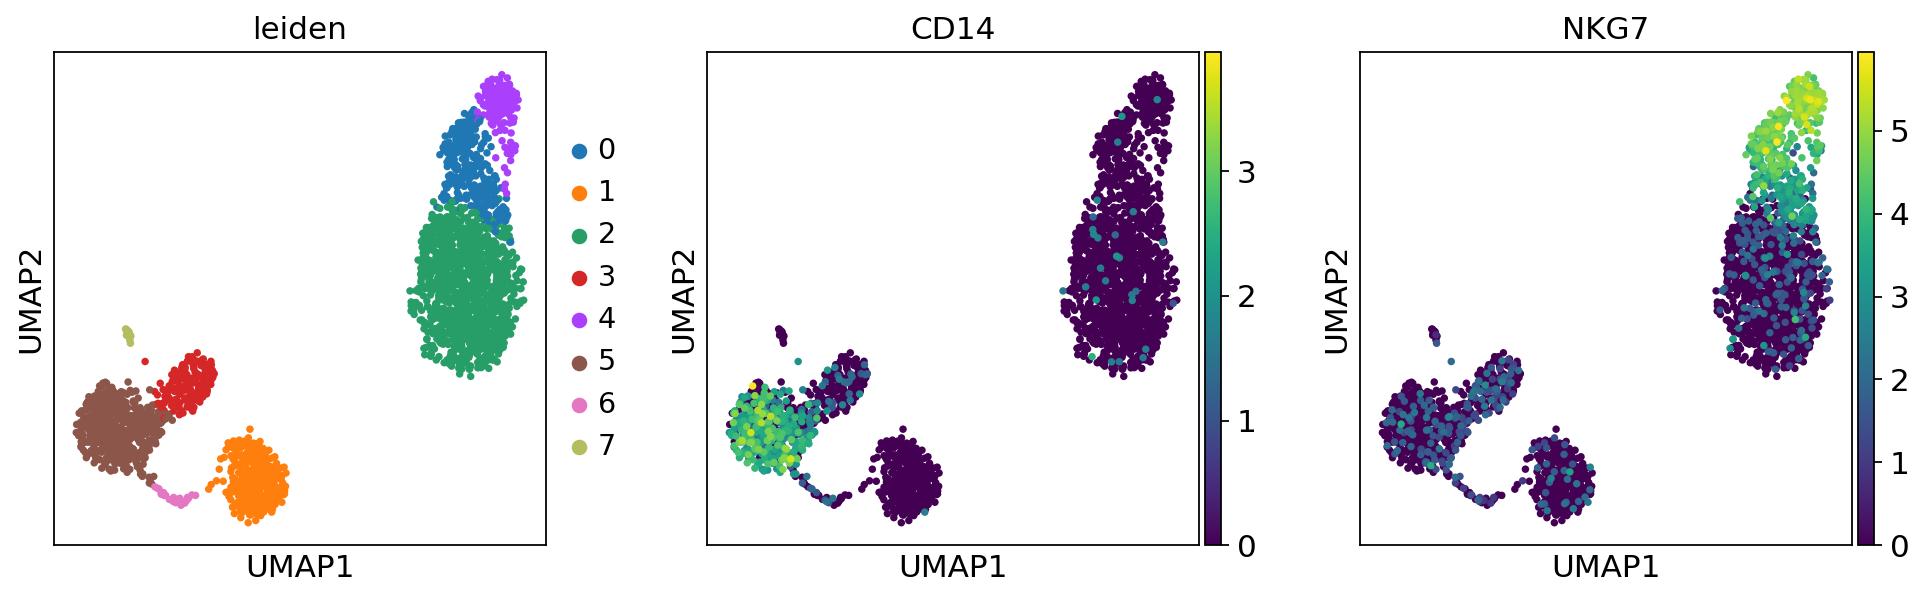

In [35]:
sc.pl.umap(adata, color=["leiden", "CD14", "NKG7"])

## Finding marker genes

Let us compute a ranking for the highly differential genes in each cluster. The simplest and fastest method to do so is the t-test.

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


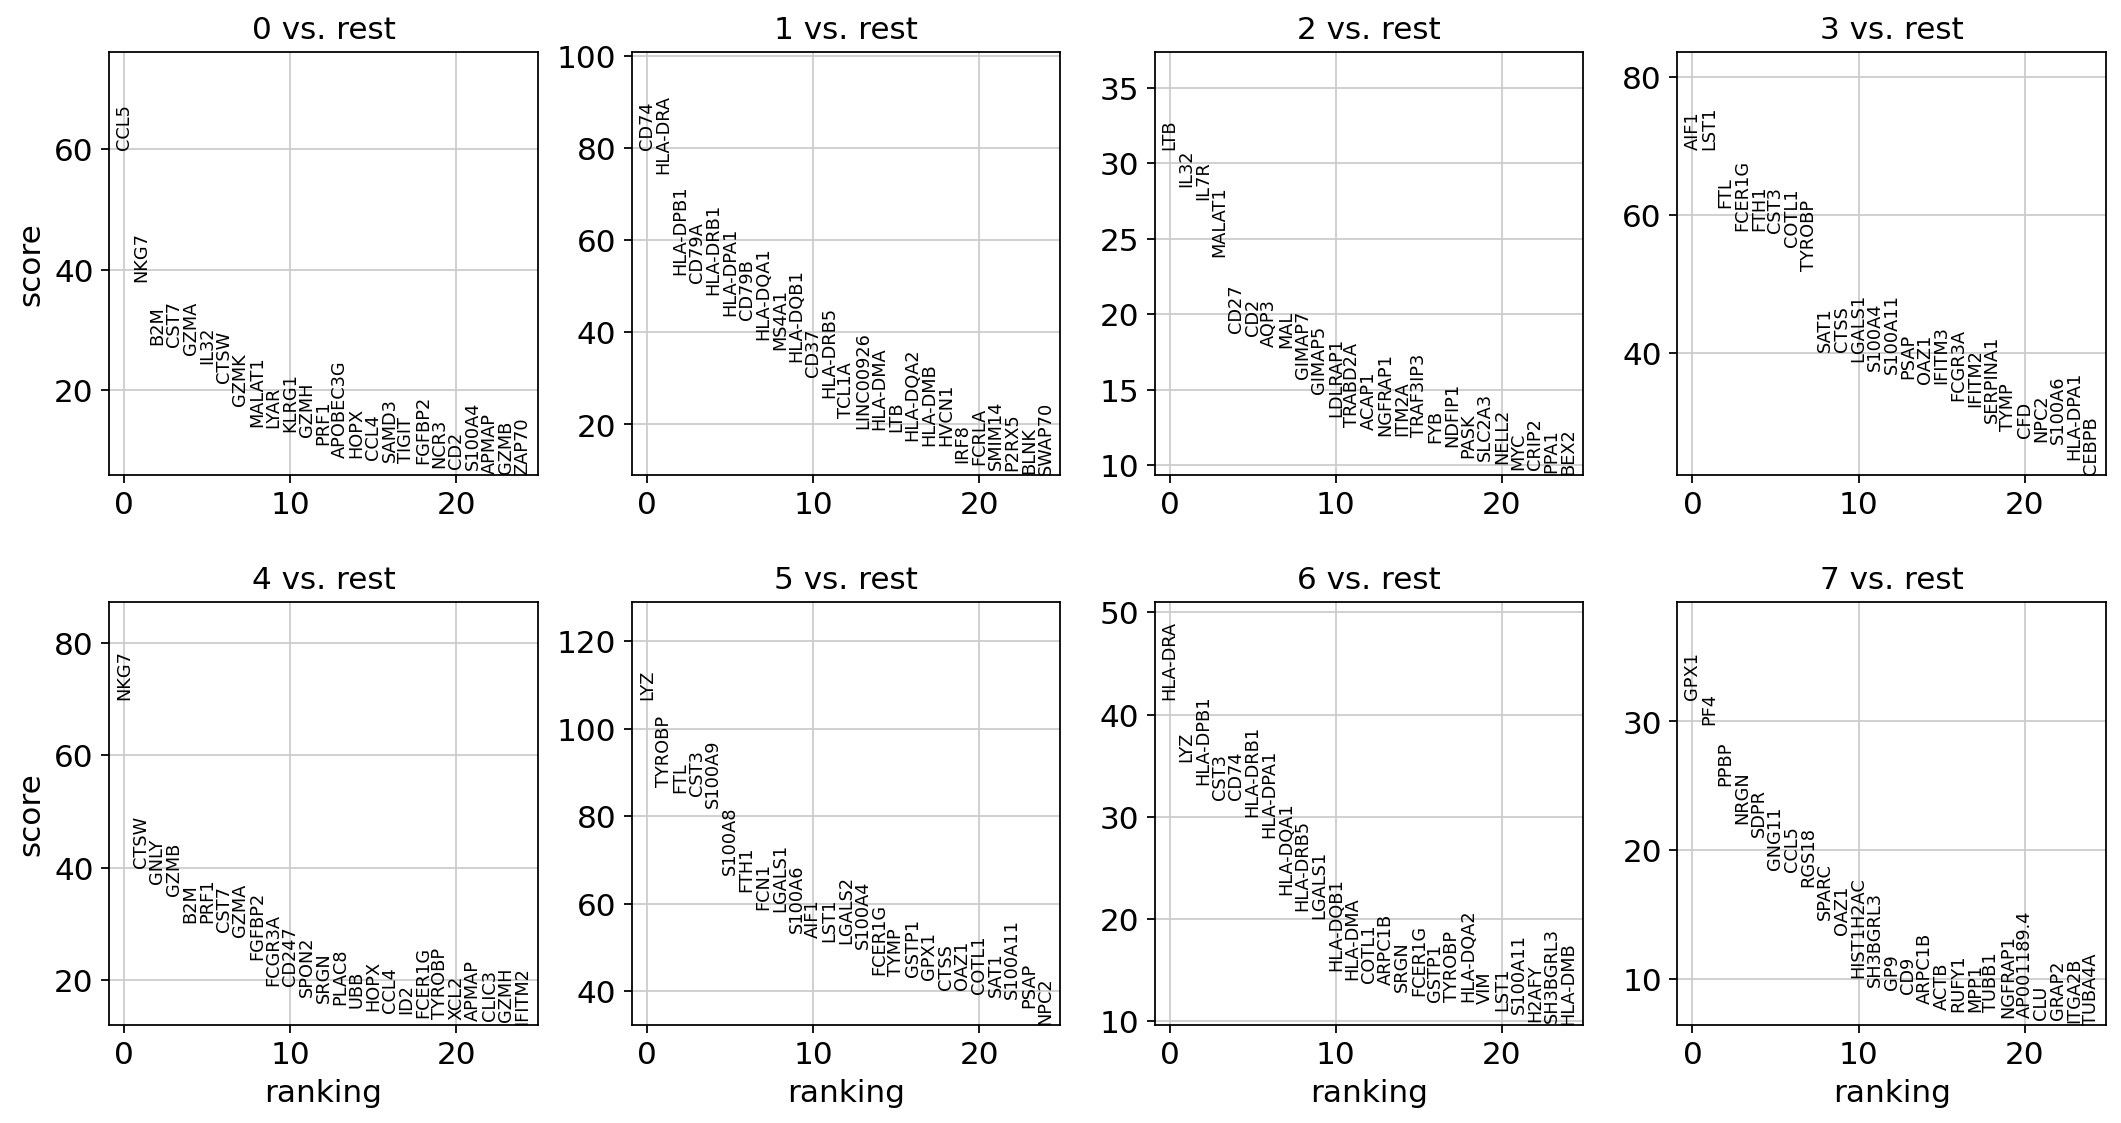

In [36]:
sc.tl.rank_genes_groups(adata, "leiden", mask_var="highly_variable", method="t-test")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [37]:
sc.settings.verbosity = 2  # reduce the verbosity

The result of a [Wilcoxon rank-sum (Mann-Whitney-U)](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test) test is very similar.
We recommend using the latter in publications, see e.g., {cite:t}`Soneson2018`.
You might also consider much more powerful differential testing packages like MAST, limma, DESeq2 and, for python, the recent diffxpy.

ranking genes
    finished (0:00:00)


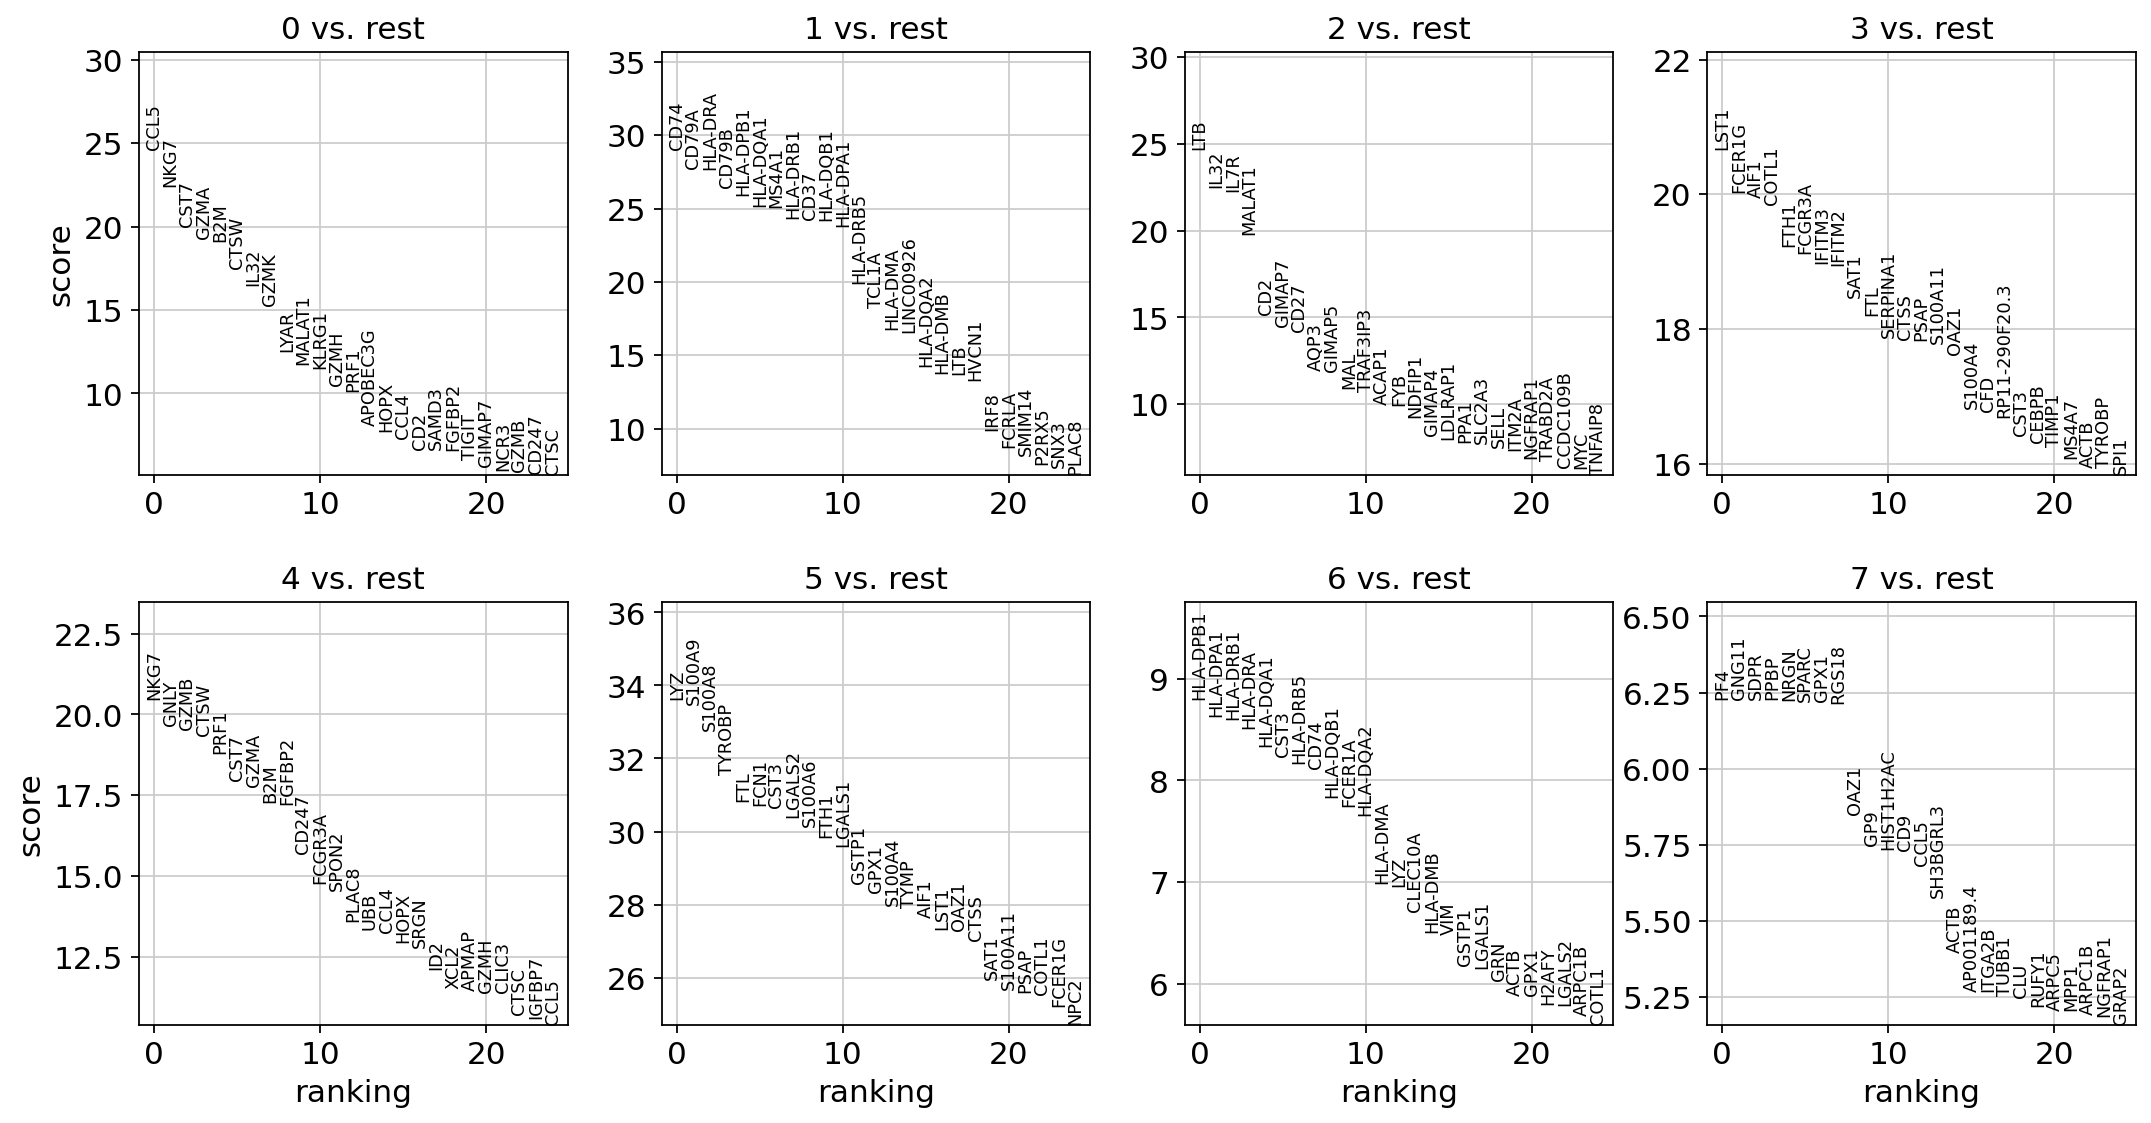

In [38]:
sc.tl.rank_genes_groups(adata, "leiden", mask_var="highly_variable", method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Save the result.

In [39]:
adata.write(results_file)

As an alternative, let us rank genes using logistic regression. For instance, this has been suggested by {cite:t}`Ntranos2019`.
The essential difference is that here, we use a multi-variate appraoch whereas conventional differential tests are uni-variate.
{cite:t}`Clark2014` has more details.

ranking genes
    finished (0:00:08)


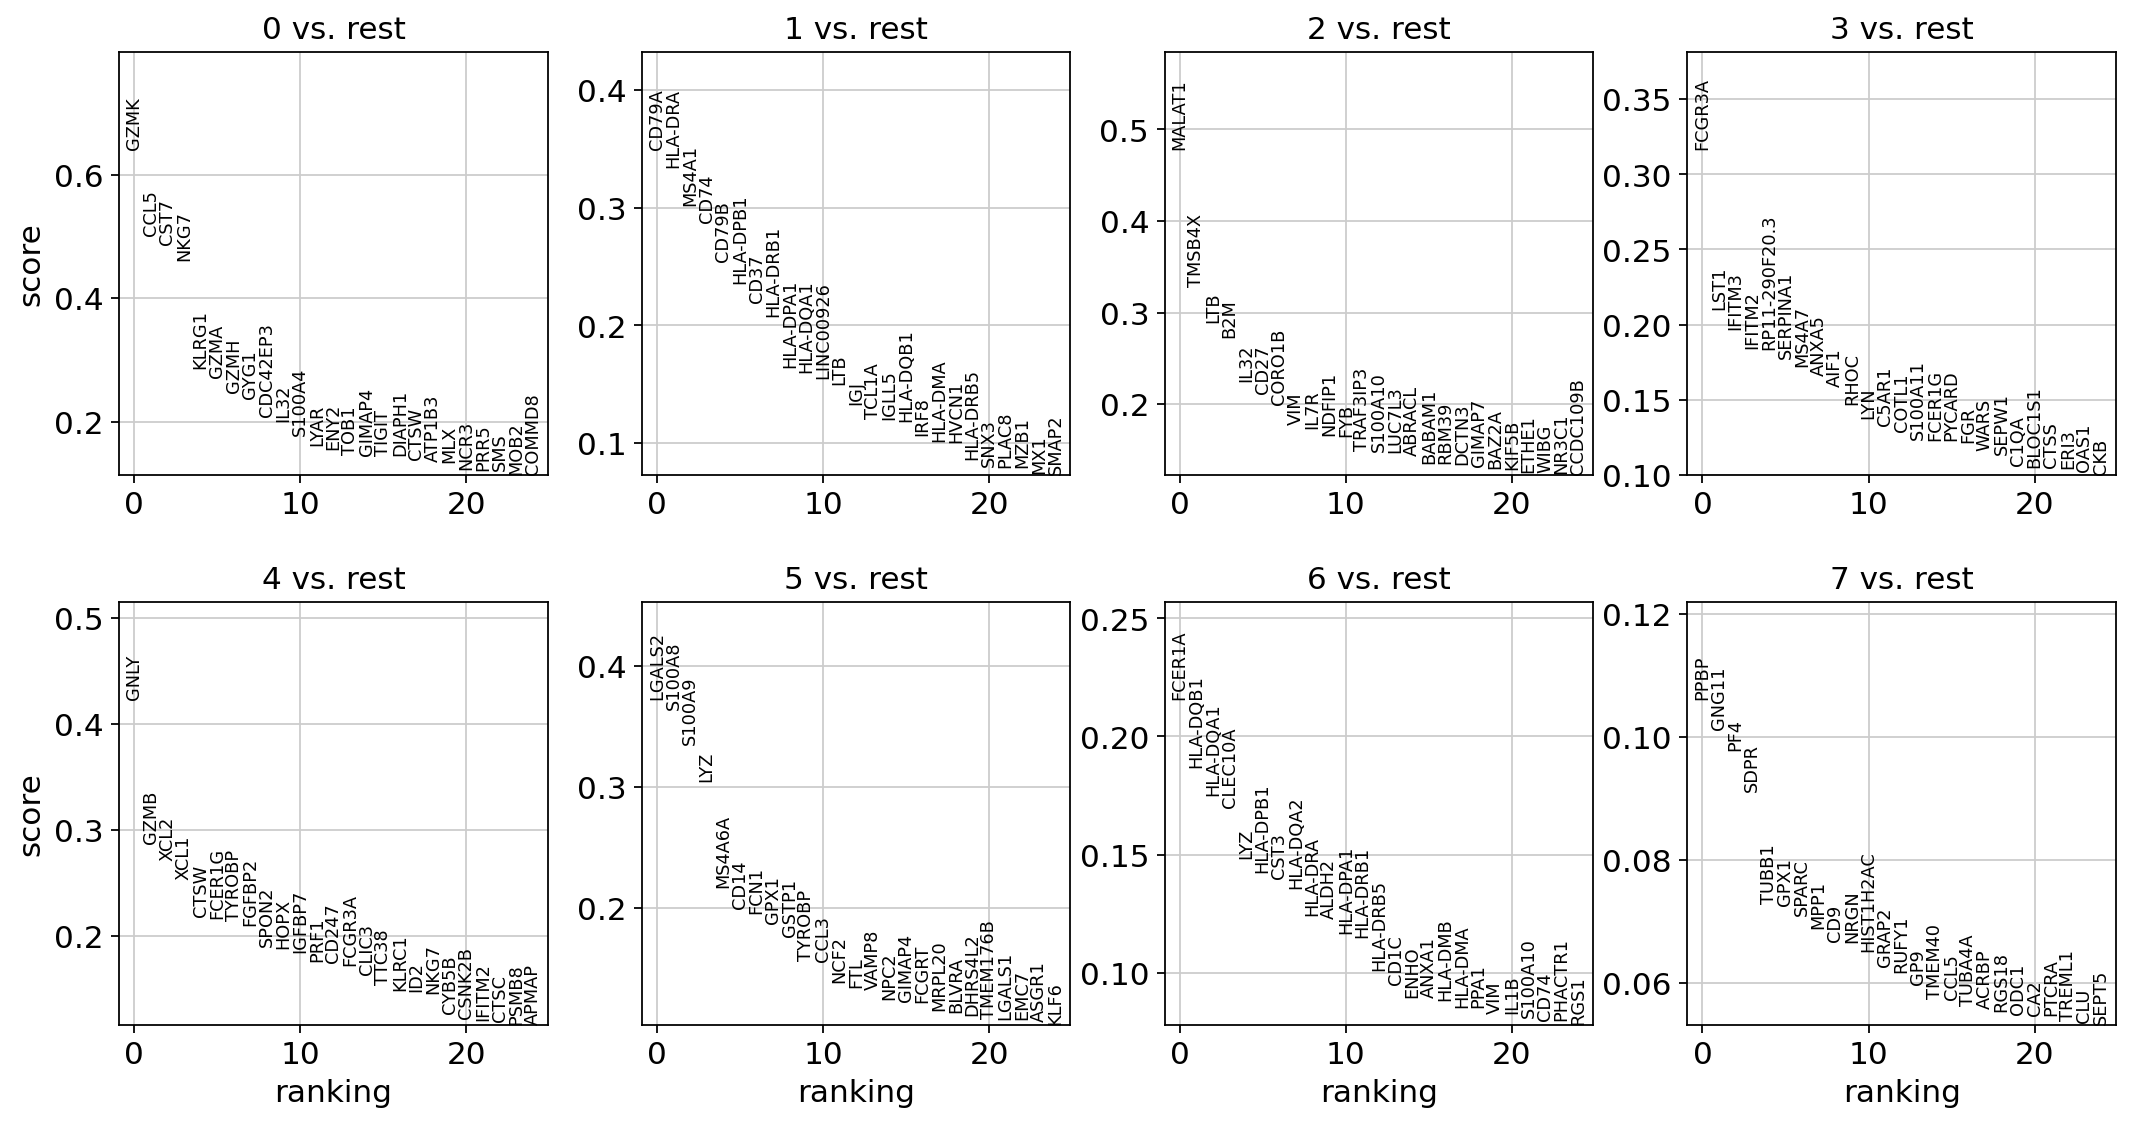

In [40]:
sc.tl.rank_genes_groups(adata, "leiden", mask_var="highly_variable", method="logreg", max_iter=1000)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Most of these genes are found in the highly expressed genes with notable exceptions like `CD8A` (see the below dotplot).

Leiden Group | Markers | Cell Type
---|---|---
0 | IL7R | CD4 T cells
1 | CD14, LYZ | CD14+ Monocytes
2 | MS4A1 |	B cells
3 | CD8A |	CD8 T cells
4 | GNLY, NKG7 | 	NK cells
5 | FCGR3A, MS4A7 |	FCGR3A+ Monocytes
6 | FCER1A, CST3 |	Dendritic Cells
7 | PPBP |	Megakaryocytes

Let us also define a list of marker genes for later reference.

In [41]:
marker_genes = [
    *["IL7R", "CD79A", "MS4A1", "CD8A", "CD8B", "LYZ", "CD14"],
    *["LGALS3", "S100A8", "GNLY", "NKG7", "KLRB1"],
    *["FCGR3A", "MS4A7", "FCER1A", "CST3", "PPBP"],
]

In [42]:
adata = sc.read(results_file)

Show the 10 top ranked genes per cluster 0, 1, ..., 7 in a dataframe.

In [43]:
pd.DataFrame(adata.uns["rank_genes_groups"]["names"]).head(5)

0         1       2       3     4       5         6      7
0  CCL5      CD74     LTB    LST1  NKG7     LYZ  HLA-DPB1    PF4
1  NKG7     CD79A    IL32  FCER1G  GNLY  S100A9  HLA-DPA1  GNG11
2  CST7   HLA-DRA    IL7R    AIF1  GZMB  S100A8  HLA-DRB1   SDPR
3  GZMA     CD79B  MALAT1   COTL1  CTSW  TYROBP   HLA-DRA   PPBP
4   B2M  HLA-DPB1     CD2    FTH1  PRF1     FTL  HLA-DQA1   NRGN

Get a table with the scores and groups.

In [44]:
result = adata.uns["rank_genes_groups"]
groups = result["names"].dtype.names
pd.DataFrame({f"{group}_{key[:1]}": result[key][group] for group in groups for key in ["names", "pvals"]}).head(5)

0_n            0_p       1_n            1_p     2_n            2_p  \
0  CCL5  6.215030e-134      CD74  2.120012e-185     LTB  1.204255e-134   
1  NKG7  4.318498e-111     CD79A  2.912929e-169    IL32  3.143175e-112   
2  CST7   3.412739e-89   HLA-DRA  3.064120e-168    IL7R  6.794049e-110   
3  GZMA   3.774764e-83     CD79B  5.052934e-154  MALAT1   2.497922e-87   
4   B2M   2.786747e-81  HLA-DPB1  4.254675e-148     CD2   7.174424e-52   

      3_n           3_p   4_n           4_p     5_n            5_p       6_n  \
0    LST1  6.675623e-95  NKG7  3.845356e-93     LYZ  7.531608e-248  HLA-DPB1   
1  FCER1G  3.445290e-89  GNLY  5.123086e-86  S100A9  1.300623e-245  HLA-DPA1   
2    AIF1  1.193730e-88  GZMB  5.256067e-85  S100A8  1.576638e-235  HLA-DRB1   
3   COTL1  1.016489e-87  CTSW  1.584864e-83  TYROBP  1.719270e-218   HLA-DRA   
4    FTH1  2.102413e-82  PRF1  9.489625e-79     FTL  9.775999e-209  HLA-DQA1   

            6_p    7_n           7_p  
0  1.394481e-18    PF4  4.722886e-10  
1  6.149335e-18  GNG11  4.733899e-10  
2  7.976594e-18   SDPR  4.733899e-10  
3  1.750535e-17   PPBP  4.744938e-10  
4  7.972192e-17   NRGN  4.800511e-10

Compare to a single cluster: 

ranking genes
    finished (0:00:00)


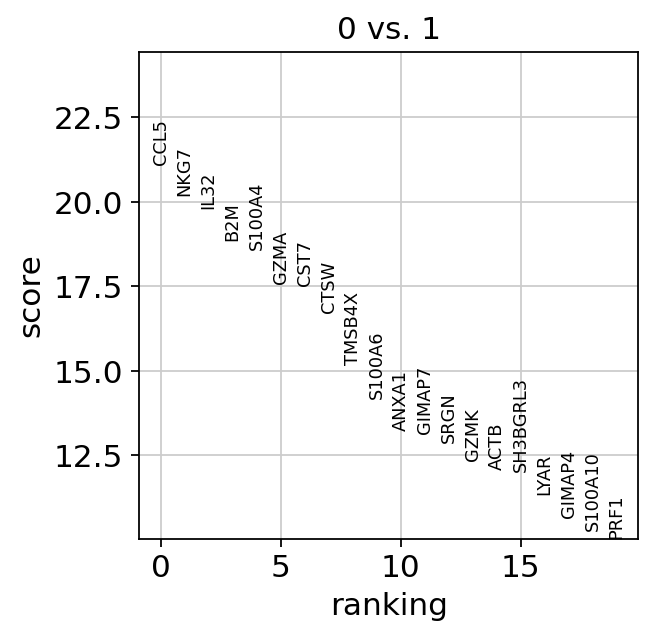

In [45]:
sc.tl.rank_genes_groups(
    adata,
    "leiden",
    mask_var="highly_variable",
    groups=["0"],
    reference="1",
    method="wilcoxon",
)
sc.pl.rank_genes_groups(adata, groups=["0"], n_genes=20)

If we want a more detailed view for a certain group, use `sc.pl.rank_genes_groups_violin`.

/config/workspace/.venv/lib/python3.10/site-packages/scanpy/plotting/_tools/__init__.py:1328: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


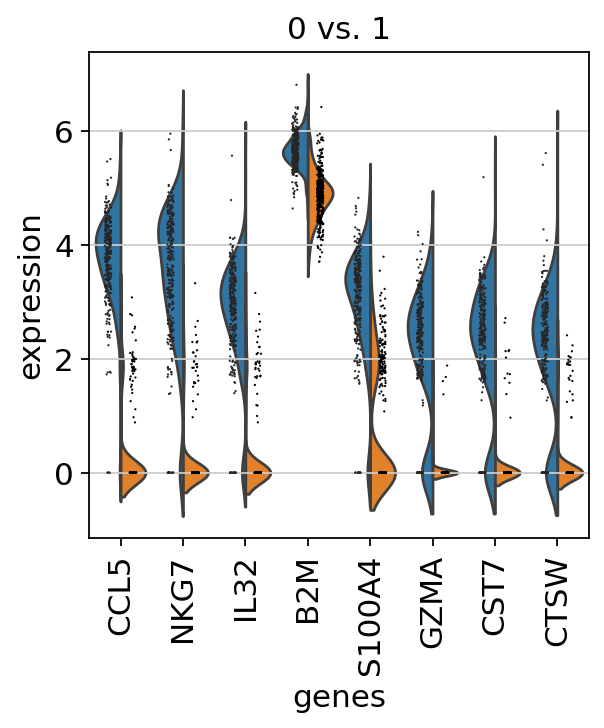

In [46]:
sc.pl.rank_genes_groups_violin(adata, groups="0", n_genes=8)

Reload the object with the computed differential expression (i.e. DE via a comparison with the rest of the groups):

In [47]:
adata = sc.read(results_file)

/config/workspace/.venv/lib/python3.10/site-packages/scanpy/plotting/_tools/__init__.py:1328: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


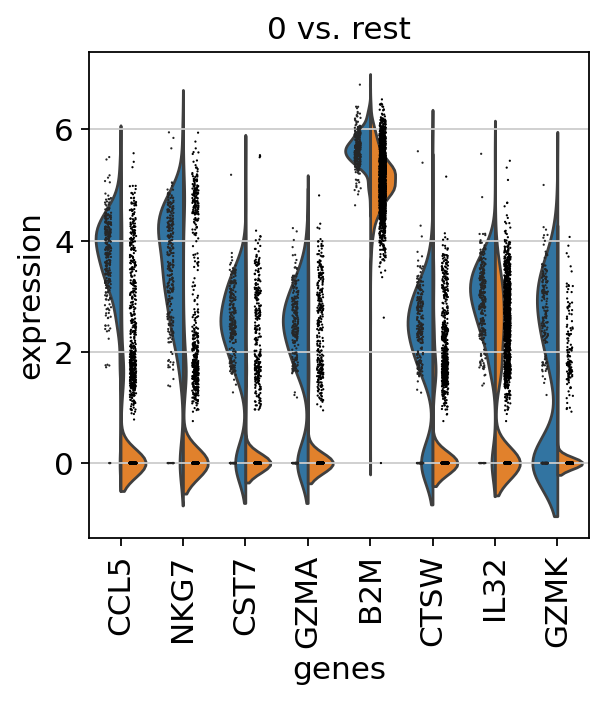

In [48]:
sc.pl.rank_genes_groups_violin(adata, groups="0", n_genes=8)

If you want to compare a certain gene across groups, use the following.

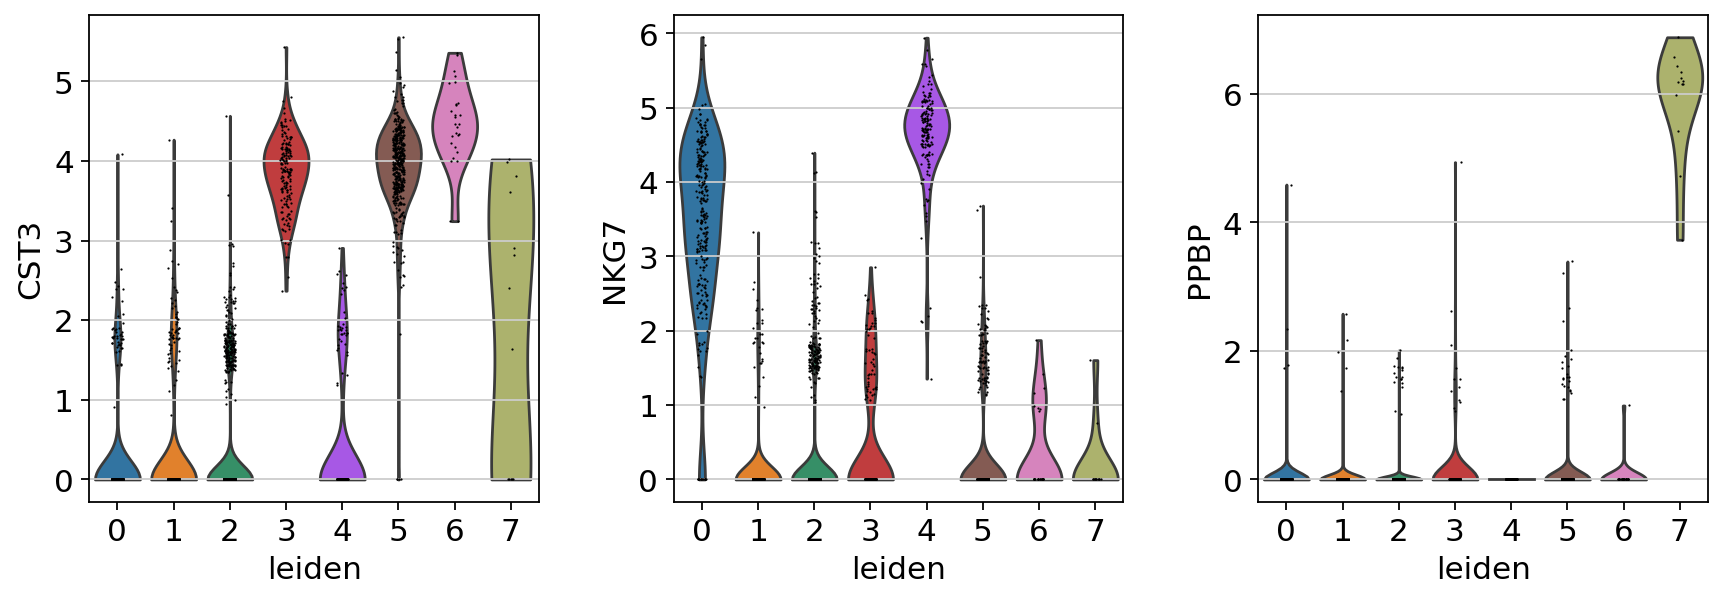

In [49]:
sc.pl.violin(adata, ["CST3", "NKG7", "PPBP"], groupby="leiden")

Actually mark the cell types.

In [50]:
new_cluster_names = [
    "CD4 T",
    "B",
    "CD14+ Monocytes",
    "NK",
    "CD8 T",
    "FCGR3A+ Monocytes",
    "Dendritic",
    "Megakaryocytes",
]
adata.rename_categories("leiden", new_cluster_names)

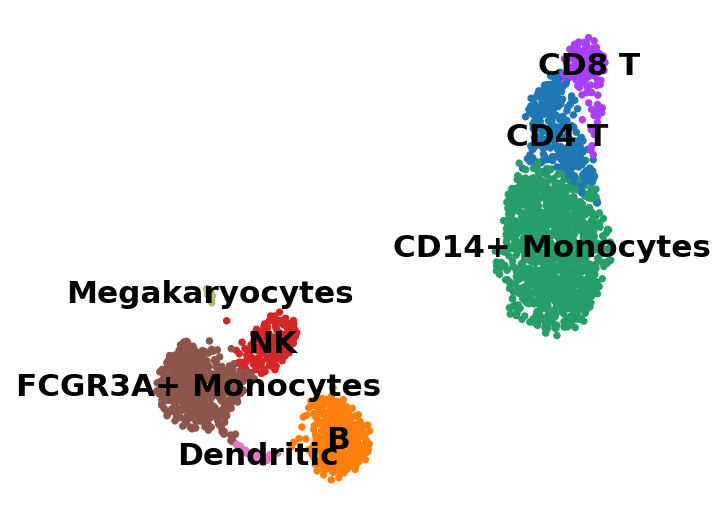

In [51]:
sc.pl.umap(adata, color="leiden", legend_loc="on data", title="", frameon=False)

Now that we annotated the cell types, let us visualize the marker genes.

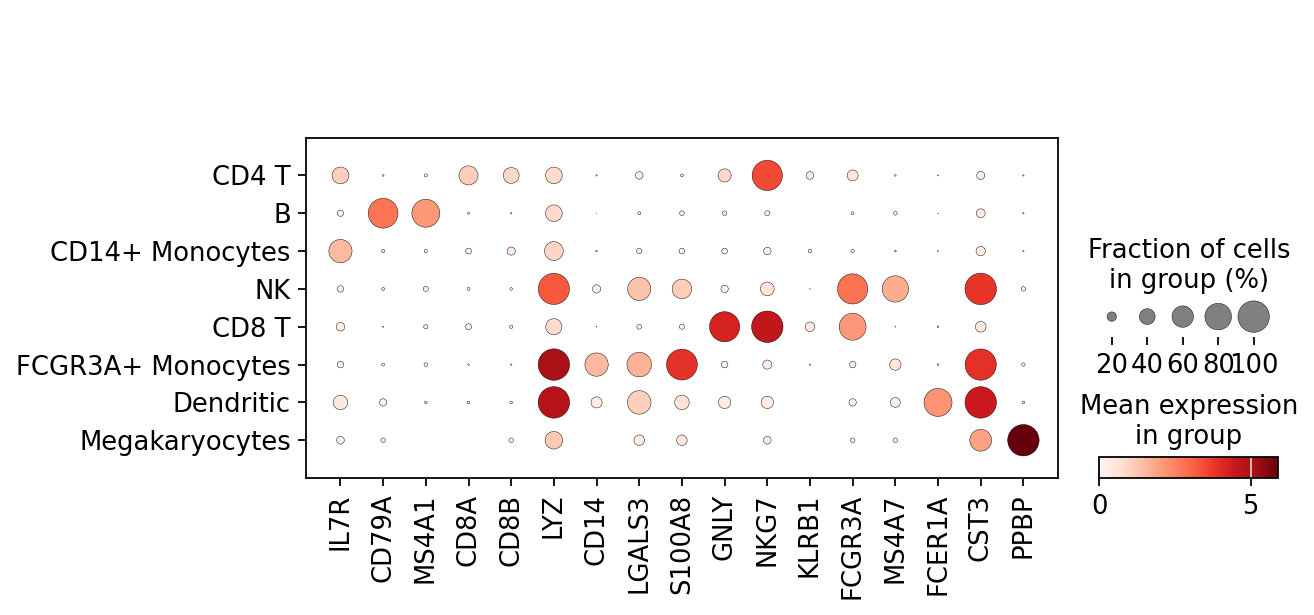

In [52]:
sc.pl.dotplot(adata, marker_genes, groupby="leiden")

There is also a very compact violin plot.

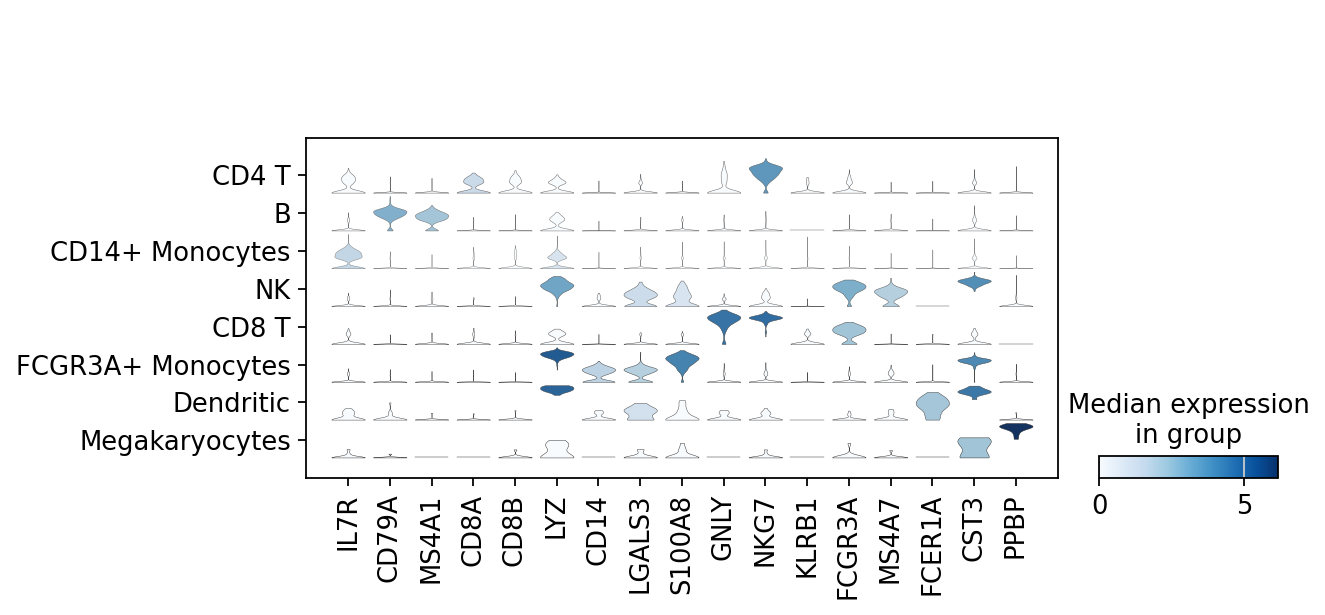

In [53]:
sc.pl.stacked_violin(adata, marker_genes, groupby="leiden")

During the course of this analysis, the AnnData accumlated the following annotations.

In [54]:
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'scaled'
    obsp: 'connectivities', 'distances'

In [55]:
# `compression='gzip'` saves disk space, and slightly slows down writing and subsequent reading
adata.write(results_file, compression="gzip")

Get a rough overview of the file using `h5ls`, which has many options - for more details see [here](https://github.com/theislab/scanpy_usage/blob/master/170505_seurat/info_h5ad.md). The file format might still be subject to further optimization in the future. All reading functions will remain backwards-compatible, though.